# EXPLORATION 3 : 카메라 스티커앱 만들기 첫걸음

## 보완할 부분
- 기울어진 얼굴에 스티커 기울여서 붙이기

## 1. 이미지 확인

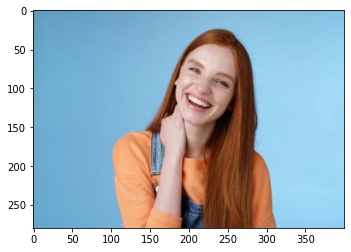

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/girl.png'
img_bgr = cv2.imread(my_image_path)                   #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (400, 280))             # 640x360의 크기로 Resize
img_show = img_bgr.copy()                             #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # plt.imshow 이전에 RGB 이미지로 바꾸기
plt.imshow(img_rgb)
plt.show()

## 2. detector를 이용해서 얼굴의 bounding box를 추출

rectangles[[(171, 58) (264, 151)]]


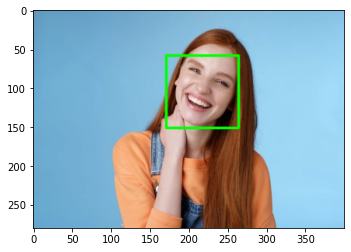

In [2]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언 
dlib_rects = detector_hog(img_rgb, 2)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 랜드마크 모델 불러온 다음 출력하기

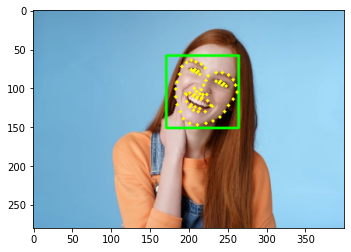

In [3]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용 위치 확인 및 회전각 구하기

In [4]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 회전 각 구하기
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

(x,y) : (216,55)
(w,h) : (94,94)
-26.56505117707799


## 5. 스티커 불러오기

In [5]:
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'  
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 리사이즈
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print (img_sticker.shape)

(94, 94, 3)


## 6. 스티커 회전하기

(94, 94, 3)


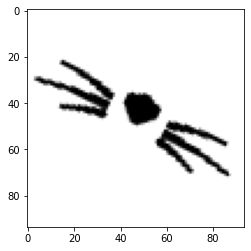

In [6]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

In [7]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정 (이미지 시작점은 top-left 좌표)
refined_x = []
refined_y = []
for i in range(1):
    refined_x.append(x - w//2)  # left
    refined_y.append(y)     # top

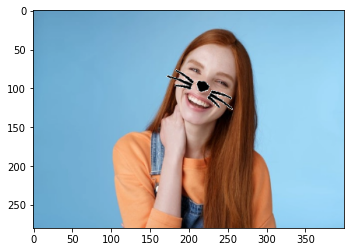

In [8]:
for i in range(1):
    sticker_area = img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]]
    img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커가 적절히 기울여진 다음 원본 사진에 붙는걸 볼 수 있다.